# **Mapping the potential supratidal extent of Australia**

Python imports and configuration settings that set up various libraries and tools for geospatial and environmental data analysis.

In [1]:
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
import pandas as pd
from scipy.ndimage import sobel
import sys
sys.path.insert(1, "/home/jovyan/dea-notebooks/Tools")
import datacube
dc = datacube.Datacube()
from datacube.utils.cog import write_cog
from datacube.utils.geometry import Geometry
from dea_tools.spatial import xr_rasterize
from dea_tools.landcover import plot_land_cover

### Tide modelling tools
sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb, display_map
from dea_tools.coastal import model_tides, tidal_tag, pixel_tides, tidal_stats

### Virtual product
import importlib
from datacube.virtual import catalog_from_file
from datacube.virtual import DEFAULT_RESOLVER
catalog = catalog_from_file('../virtual_products/virtual_product_cat_wcf.yaml')

# **Study Area 1: Newcastle**

Setting up a data load query for geospatial data within specific spatial and temporal extents. It defines query parameters like geographical coordinates (x and y), time range, measurements, output coordinate reference system and resolution. 

In [2]:
# Set up data load query
query = {
    'x': (151.25, 152.41),
    'y': (-32.59, -33.41),
    'time': ('2020', '2020'),
    'measurements': ['nbart_red', 'nbart_green', 'nbart_blue'],
    'output_crs': 'EPSG:3577',
    'resolution': (-30, 30),
    'group_by': 'solar_day',
    'dask_chunks': {},}

display_map(x=query['x'], y=query['y'])

Importing a time series of Landsat 8 observations with specific filtering criteria as an xarray.Dataset.

Link to the product: https://explorer.sandbox.dea.ga.gov.au/products/ga_ls8c_ard_3

In [3]:
# Load available data from Landsat 8
ds = load_ard(dc=dc,
              products=["ga_ls8c_ard_3"],
              min_gooddata=0.9,
              mask_filters=[("opening", 5), ("dilation", 5)],
              ls7_slc_off=False,
              **query)

# Print output data
ds

Finding datasets
    ga_ls8c_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 7 out of 65 time steps with at least 90.0% good quality pixels
Applying morphological filters to pixel quality mask: [('opening', 5), ('dilation', 5)]
Applying fmask pixel quality/cloud mask
Returning 7 time steps as a dask array


/home/jovyan/Tools/dea_tools/datahandling.py:492: UserWarning: As of `dea_tools` v0.3.0, pixel quality masks are inverted before being passed to `mask_filters` (i.e. so that good quality/clear pixels are False and poor quality pixels/clouds are True). This means that 'dilation' will now expand cloudy pixels, rather than shrink them as in previous versions.
  warnings.warn(


<xarray.Dataset>
Dimensions:      (time: 7, y: 3572, x: 4018)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-25T23:43:26.630205 ... 2020-12...
  * y            (y) float64 -3.688e+06 -3.688e+06 ... -3.795e+06 -3.795e+06
  * x            (x) float64 1.772e+06 1.772e+06 ... 1.893e+06 1.893e+06
    spatial_ref  int32 3577
Data variables:
    nbart_red    (time, y, x) float32 dask.array<chunksize=(1, 3572, 4018), meta=np.ndarray>
    nbart_green  (time, y, x) float32 dask.array<chunksize=(1, 3572, 4018), meta=np.ndarray>
    nbart_blue   (time, y, x) float32 dask.array<chunksize=(1, 3572, 4018), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

The "tidal_stats" function helps to assess how the range of tides observed within the specified study area by satellites matches the modeled tidal range. It achieves this by utilizing the tidal model (FES2014) to predict tide heights at regular intervals (typically every two hours) throughout the entire time span covered by the satellite dataset. 

A single tide height for each satellite image is modeled, using the centroid of the image as a tide modeling location. Note, that the modeling location was manually set to the location of the Stockton Bridge gauge station to obtain the best possible validation.

Using user-supplied tide modelling location: 151.78, -32.88
Modelling tides using FES2014
Modelling tides using FES2014
                                             tide_model    tide_m
time                       x        y                            
2020-01-25 23:43:26.630205 151.7838 -32.8849    FES2014  0.784777
2020-01-26 01:43:26.630205 151.7838 -32.8849    FES2014  0.295182
2020-01-26 03:43:26.630205 151.7838 -32.8849    FES2014 -0.363691
2020-01-26 05:43:26.630205 151.7838 -32.8849    FES2014 -0.642644
2020-01-26 07:43:26.630205 151.7838 -32.8849    FES2014 -0.385937
...                                                 ...       ...
2020-12-26 15:43:26.630205 151.7838 -32.8849    FES2014 -0.211706
2020-12-26 17:43:26.630205 151.7838 -32.8849    FES2014  0.283055
2020-12-26 19:43:26.630205 151.7838 -32.8849    FES2014  0.621460
2020-12-26 21:43:26.630205 151.7838 -32.8849    FES2014  0.494973
2020-12-26 23:43:26.630205 151.7838 -32.8849    FES2014  0.029098

[4033 rows x 2 column

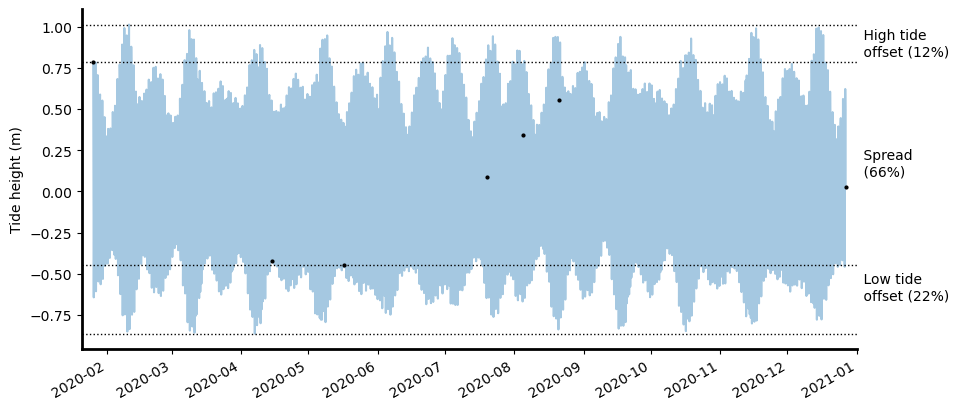

In [4]:
out_stats = tidal_stats(ds, tidepost_lat = -32.8849, tidepost_lon = 151.7838)

# Save the figure as a PNG file in the current directory
#plt.savefig('modeled_tides_over_time_2020.png', dpi=300, format='png', bbox_inches='tight')

Statistically compares the tides modeled for each satellite observation against the full modeled tidal range. This comparison can be used to evaluate whether the tides observed by satellites (e.g. Landsat) are biased compared to the natural tidal range (e.g. fail to observe either the highest or lowest tides etc).

In [5]:
out_stats

tidepost_lat        -32.885
tidepost_lon        151.784
observed_mean_m       0.132
all_mean_m            0.000
observed_min_m       -0.446
all_min_m            -0.863
observed_max_m        0.785
all_max_m             1.012
observed_range_m      1.231
all_range_m           1.875
spread                0.657
low_tide_offset       0.222
high_tide_offset      0.121
dtype: float64

With the help of the provided statistics above, one can calculate the ratio between the modeled and observed maximum tide

In [6]:
Factor = out_stats.all_max_m / out_stats.observed_max_m
print('The factor beteween the modeled and observed maximum tide is =', round(Factor, 2))

The factor beteween the modeled and observed maximum tide is = 1.29


**Validation**

Validating the modeled tides with real measured tidal data is essential for assessing accuracy and ensuring the reliability of the FES2014 model.

For "Study Area 1: Newcastle", a dataset from the Newcastle gauge at Stockton Bridge (https://mhl.nsw.gov.au/Station-210456).

Coordinates of the measuring station: Latitude: -32.8849, Longitude: 151.7838

In [7]:
pip install openpyxl

  Using cached openpyxl-3.1.2-py2.py3-none-any.whl (249 kB)
  Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)
Note: you may need to restart the kernel to use updated packages.


Loading the dataset from the Newcastle gauge at Stockton Bridge.

In [8]:
# Define the file path
file = 'Validation_data/1_Newcastle/StocktonBridge.xlsx'

# Read the CSV file and specify the sheet name
df = pd.read_excel(file)

# Convert 'Date' column to string format
df['Date'] = df['Date'].astype(str)

# Convert 'Time' column to string format
df['Time'] = df['Time'].astype(str)

# Combine 'Date' and 'Time' columns into a single datetime column
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Drop unnecessary columns
df = df.drop(['Date', 'Time', 'State of value'], axis=1)

# Display the DataFrame with the new 'datetime' column
df

,Value[m],datetime
0,0.329,2017-01-01 00:00:00
1,0.233,2017-01-01 00:15:00
2,0.159,2017-01-01 00:30:00
3,0.102,2017-01-01 00:45:00
4,0.053,2017-01-01 01:00:00
...,...,...
236406,0.517,2023-10-05 11:15:00
236407,0.573,2023-10-05 11:30:00
236408,0.617,2023-10-05 11:45:00
236409,0.673,2023-10-05 12:00:00


Visualization of the dataset from the Newcastle gauge at Stockton Bridge.

/tmp/ipykernel_190/4194813125.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = pd.to_datetime(df['datetime'])


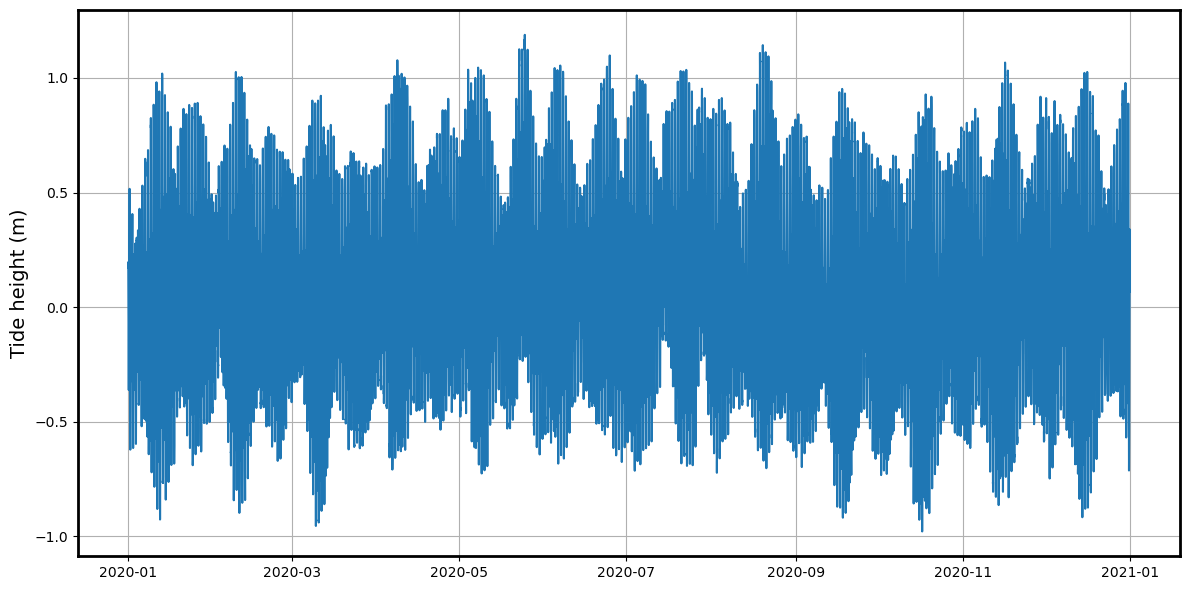

In [9]:
# Clean the data: Replace non-numeric values with NaN
df['Value[m]'] = pd.to_numeric(df['Value[m]'], errors='coerce')

# Remove rows with NaN values in the 'Value[m]' column
df = df.dropna(subset=['Value[m]'])

# Filter the DataFrame to include only data from the year 2020
df['datetime'] = pd.to_datetime(df['datetime'])
df_2020 = df[df['datetime'].dt.year == 2020]
df_2020 = df_2020.reset_index(drop=True)
df_2020.rename(columns={'Value[m]': 'obs_tide_m'}, inplace=True)

# Plotting
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.plot(df_2020['datetime'], df_2020['obs_tide_m'], label='Tide')
#plt.xlabel('Datetime')
plt.ylabel('Tide height (m)', fontsize=14)
#plt.title('Tide over time at Stockton Bridge Station')
plt.grid(True)
plt.tight_layout()

# Show and save the plot
#plt.savefig('measured_tides_over_time_2020.png', dpi=300, format='png', bbox_inches='tight')
plt.show()

In [10]:
# Find the minimum, maximum, and range of the measured tides
min_measured_tide = df_2020['obs_tide_m'].min()
max_measured_tide = df_2020['obs_tide_m'].max()
range_measured_tide = max_measured_tide - min_measured_tide

print(f"Minimum Measured Tide: {min_measured_tide} meters")
print(f"Maximum Measured Tide: {max_measured_tide} meters")
print(f"Range of Measured Tides: {range_measured_tide} meters")

Minimum Measured Tide: -0.979 meters
Maximum Measured Tide: 1.188 meters
Range of Measured Tides: 2.167 meters


Renewed modeling of tides with the FES2014 model at the Newcastle Gauge Station at Stockton Bridge using 15 minute intervals.

In [11]:
# Set of times to model tides for
date_list = pd.date_range(start="2020-01-01", end="2021-01-01", freq="15min")

# Run the FES2014 tidal model
tide_df = model_tides(x=[151.7838], y=[-32.8849], time=date_list)
tide_df = tide_df.reset_index()
tide_df.rename(columns={'time': 'datetime'}, inplace=True)
tide_df.rename(columns={'tide_m': 'mod_tide_m'}, inplace=True)
tide_df = tide_df.drop(columns=['x', 'y', 'tide_model'])

# Print outputs
tide_df

Modelling tides using FES2014


,datetime,mod_tide_m
0,2020-01-01 00:00:00,0.344825
1,2020-01-01 00:15:00,0.387845
2,2020-01-01 00:30:00,0.427075
3,2020-01-01 00:45:00,0.461860
4,2020-01-01 01:00:00,0.491578
...,...,...
35132,2020-12-31 23:00:00,0.844947
35133,2020-12-31 23:15:00,0.857176
35134,2020-12-31 23:30:00,0.858804
35135,2020-12-31 23:45:00,0.849584


Merging the observed tidal data from the Newcastle Gauge at Stockton Bridge and the modeled tidal data (FES2014) based on 'datetime'. After that, the difference between the observed and modeled data is calculated.

In [12]:
# Ensure both DataFrames have 'datetime' columns
df_2020['datetime'] = pd.to_datetime(df_2020['datetime'])
tide_df['datetime'] = pd.to_datetime(tide_df['datetime'])

# Merge the two DataFrames based on the 'datetime' column
merged_df = df_2020.merge(tide_df, on='datetime', how='inner')

# Calculate the difference between 'Value[m]' and 'tide_m' columns
merged_df['Difference'] = merged_df['obs_tide_m'] - merged_df['mod_tide_m']

# Rearrange order 
merged_df = merged_df[['datetime', 'obs_tide_m', 'mod_tide_m', 'Difference']]

merged_df

,datetime,obs_tide_m,mod_tide_m,Difference
0,2020-01-01 00:00:00,0.173,0.344825,-0.171825
1,2020-01-01 00:15:00,0.179,0.387845,-0.208845
2,2020-01-01 00:30:00,0.194,0.427075,-0.233075
3,2020-01-01 00:45:00,0.196,0.461860,-0.265860
4,2020-01-01 01:00:00,0.180,0.491578,-0.311578
...,...,...,...,...
35127,2020-12-31 22:45:00,0.291,0.822539,-0.531539
35128,2020-12-31 23:00:00,0.243,0.844947,-0.601947
35129,2020-12-31 23:15:00,0.196,0.857176,-0.661176
35130,2020-12-31 23:30:00,0.125,0.858804,-0.733804


Visualization of the difference between the observed and modeled tidal data.

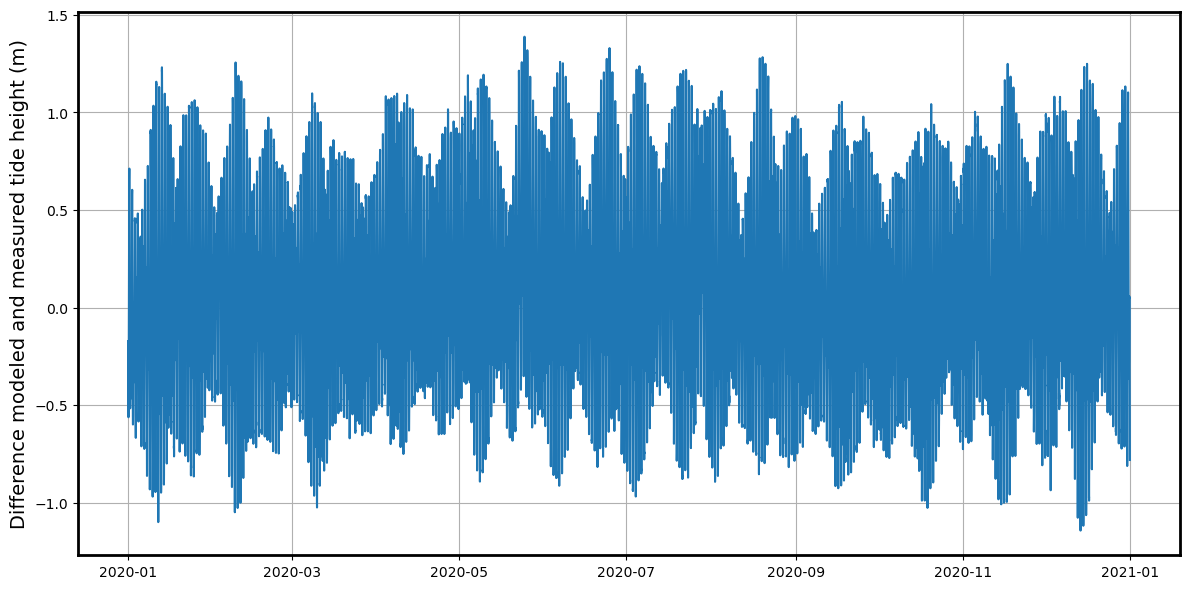

In [13]:
# Create a plot of the difference over time
plt.figure(figsize=(12, 6))
plt.plot(merged_df['datetime'], merged_df['Difference'], label='Difference')
#plt.xlabel('Datetime')
plt.ylabel('Difference modeled and measured tide height (m)', fontsize=14)
#plt.title('Difference Between obs_tide_m and mod_tide_m over Time (Year 2020)')
plt.grid(True)
plt.tight_layout()

# Show and save the plot
plt.savefig('difference_observed_vs_modeled_tides_2020.png', dpi=300, format='png', bbox_inches='tight')
plt.show()

Creation of boxplots to compare the tidal range of the observed and modeled tidal data at Newcastle gauge station.

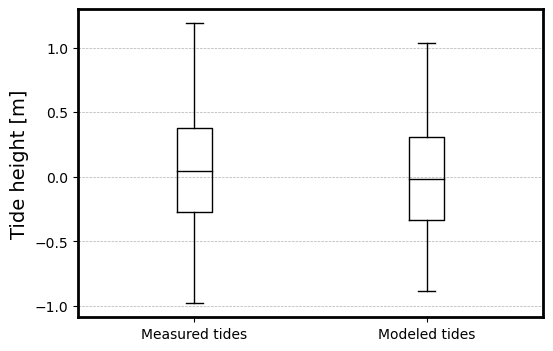

In [14]:
# Create a boxplot to compare the two datasets
data_to_plot = [df_2020['obs_tide_m'], tide_df['mod_tide_m']]
labels = ['Measured tides', 'Modeled tides']

plt.figure(figsize=(6, 4))

# Define median properties to change the median line color to black
medianprops = dict(linewidth=1, color='black')

# Create the boxplot with specified median properties
bp = plt.boxplot(data_to_plot, labels=labels, medianprops=medianprops)

# Set the fontsize for ylabel
plt.ylabel('Tide height [m]', fontsize=14)

# Apply a finer grid
plt.grid(axis='y', linestyle='--', linewidth=0.5)

# Show and save the plot
#plt.savefig('measured_vs_modeled_tides_boxplot_2020.png', dpi=300, format='png', bbox_inches='tight')
plt.show()

In [15]:
max_mod_tide = merged_df['mod_tide_m'].max()
max_obs_tide = merged_df['obs_tide_m'].max()
difference = max_obs_tide - max_mod_tide
ratio = max_obs_tide / max_mod_tide

print('The maximum modeled tide is', round(max_mod_tide, 2), 'meters above sea level')
print('The maximum observed tide is', round(max_obs_tide, 2), 'meters above sea level')
print('The difference between the maximum modeled and observed tide is', round(difference, 2), 'meters')
print('The ratio between the maximum modeled and observed tide is', round(ratio, 2))

The maximum modeled tide is 1.04 meters above sea level
The maximum observed tide is 1.19 meters above sea level
The difference between the maximum modeled and observed tide is 0.15 meters
The ratio between the maximum modeled and observed tide is 1.15


One can now multiply the maximum modeled tide with a certain 'Factor' [-] to push the maximum tide further inland and separate elevation ranges above the highest astronomical tides. These elevations ranges are subject to storm surges or the influence of weather conditions and supratidal forest is likely to be found there.

In [16]:
# Define the factor [-]
Factor = 10

# Calculation of the added / multiplied modeled height
Mod_height = out_stats.all_max_m * Factor

print('The multiplied tide is =', round(Mod_height, 2), '(max modeled tide)') 

The multiplied tide is = 10.12 (max modeled tide)


The maximum modeled tide represents the lower end of the extent of the supratidal zone (Min_STZ).

The maximum modeled tide multiplied with a certain factor represents the upper end of the extent of the supratidal zone (Max_STZ).

In [17]:
Max_STZ = Mod_height
Min_STZ = out_stats.all_max_m

print('The extent of the supratidal zone ranges between', round(out_stats.all_max_m, 2), 'm and', round(Mod_height, 2), 'm (above sea level)') 

The extent of the supratidal zone ranges between 1.01 m and 10.12 m (above sea level)


The next step is loading various datasets / products using the datacube (dc) library. Therefore, a new query with only spatial and temporal extents and resolution needs to be defined.

In [18]:
# Set up data load query
query = {
    'x': (151.25, 152.41),
    'y': (-32.59, -33.41),
    'time': ('2020', '2020'),
    'resolution': (-30, 30),}

# Extract specific keys and create a new dictionary without 'time'
query_notime = {key: query[key] for key in query.keys() - {'time'}}

The datasets / products include Digital elevation data (DEM) from the Shuttle Radar Topography Mission (SRTM), an intertidal extents model (item_v2), data related to mangrove cover and a woody cover virtual product.

Here you can see the product catalogue: https://explorer.sandbox.dea.ga.gov.au/products

Afterwards, several binary mask are created:

- A binary mask for 'not_intertidal' areas. This mask is defined as 'True' in areas where there are no intertidal areas.

- A binary mask for "not mangrove" areas. This mask is defined as 'True' where there are no mangroves.

- A binary mask for "woody cover" areas. This mask is defined as 'True' where there is woody cover (with threshold to exclude saltmarsh).

- A binary mask for elevation thresholds for the Shuttle Radar Topography Mission (SRTM) data. It checks whether the elevation values are within a specified range. If the elevation falls within this range, the corresponding cells in 'Elevation_threshold_mask' are marked as 'True'.

Furthermore, the slope (gradient) of the elevation data is calculated (using the Sobel filter, which measures the rate of change of elevation). It sets threshold values for the slope, where values between 'slope_min' and 'slope_max' are considered, resulting in...

- A binary mask 'Slope_threshold_mask' that is 'True' where the slope falls within the defined range.

In addition, it combines the elevation and slope masks , resulting in...

- A binary mask called 'AHD_threshold_srtm' that is True only for areas where both elevation and slope conditions are met.

Finally, it removes the time dimension from the 'not_mangrove,' 'AHD_threshold_srtm,' and 'not_intertidal' masks, making them 2D binary masks for the specified area.

In [19]:
# Load STRM (Shuttle Radar Topography Mission) DEM (Digital elevation model)
srtm_ds = dc.load(product = 'ga_srtm_dem1sv1_0', output_crs="EPSG:3577", **query_notime)
srtm = srtm_ds.dem_h


# Load item_v2 (Intertidal extents model)
item_ds = dc.load(product = 'item_v2', output_crs="EPSG:3577", **query_notime)
item = item_ds.relative


# Load mangrove cover
DEAmangrove = dc.load(product = 'ga_ls_mangrove_cover_cyear_3', output_crs="EPSG:3577", **query)

# if no mangroves within AOI, create dummy xr.dataarray
if DEAmangrove.data_vars == {}:
    mangrove = xr.DataArray(np.zeros_like(srtm), coords=srtm.coords, dims=srtm.dims, attrs=srtm.attrs)
else:
    # get output of mangrove == 1, not mangrove == 0
    mangrove = (DEAmangrove.canopy_cover_class != 255)

In [20]:
# load in vp woody cover
sys.path.insert(1, '../virtual_products') 
# The dictionary which datacube uses to understand (resolve) the different virtual product functionality
# Need to add any aggregations for the VP you're using

# Get location of transformation
aggregation = "best_pixel_gmad"
agg_loc = importlib.import_module(aggregation)
agg_class = aggregation.split('.')[-1]

DEFAULT_RESOLVER.register('aggregate', agg_class, getattr(agg_loc, agg_class) )

In [21]:
# Need to add any tranformations for the VP you're using

# Get location of transformation
transformation = "woody_cover"
trans_loc = importlib.import_module(transformation)
trans_class = transformation.split('.')[-1]

DEFAULT_RESOLVER.register('transform', trans_class, getattr(trans_loc, trans_class) )

In [22]:
# load woody_cover vp
product = catalog['woody_cover']
woody_cover_vp = product.load(dc, **query)

# # woody cover with threshold for saltmarsh
woody_cover = xr.where(woody_cover_vp.woody_cover > 0.5, 1, 0).astype('int8')
woody_cover.attrs['crs'] = 'EPSG:3577'

/env/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/env/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [32]:
### Wrangle binary maps and create STF (Supratidal forests) mask

# Not mangrove == True
not_mangrove = (1 - mangrove)
not_mangrove = not_mangrove == 1


# Greater than Min_STZ and less than Max_STZ == True
AHD_min = Min_STZ
AHD_max = Max_STZ
# SRTM elevation thresholds
Upper_threshold_AHD = srtm <= AHD_max
Lower_threshold_AHD = srtm >= AHD_min
Elevation_threshold_mask = Upper_threshold_AHD & Lower_threshold_AHD

# Calculate the slope (gradient) of the elevation data
gradient_x = sobel(srtm, axis=1)
gradient_y = sobel(srtm, axis=0)
slope = np.sqrt(gradient_x**2 + gradient_y**2)
# Define slope thresholds
slope_min = 0
slope_max = 10
# Create a binary mask for the slope
Slope_threshold_mask = (slope >= slope_min) & (slope <= slope_max)

# Combine the elevation and slope masks using logical AND
AHD_threshold_srtm = Elevation_threshold_mask & Slope_threshold_mask


# Item_v2 (remove all intertidal areas)
not_intertidal = item == 9


# Remove time dimension
not_mangrove = not_mangrove.squeeze('time')
AHD_threshold_srtm = AHD_threshold_srtm.squeeze('time')
not_intertidal = not_intertidal.squeeze('time')

Individual visualization of all created binary maps

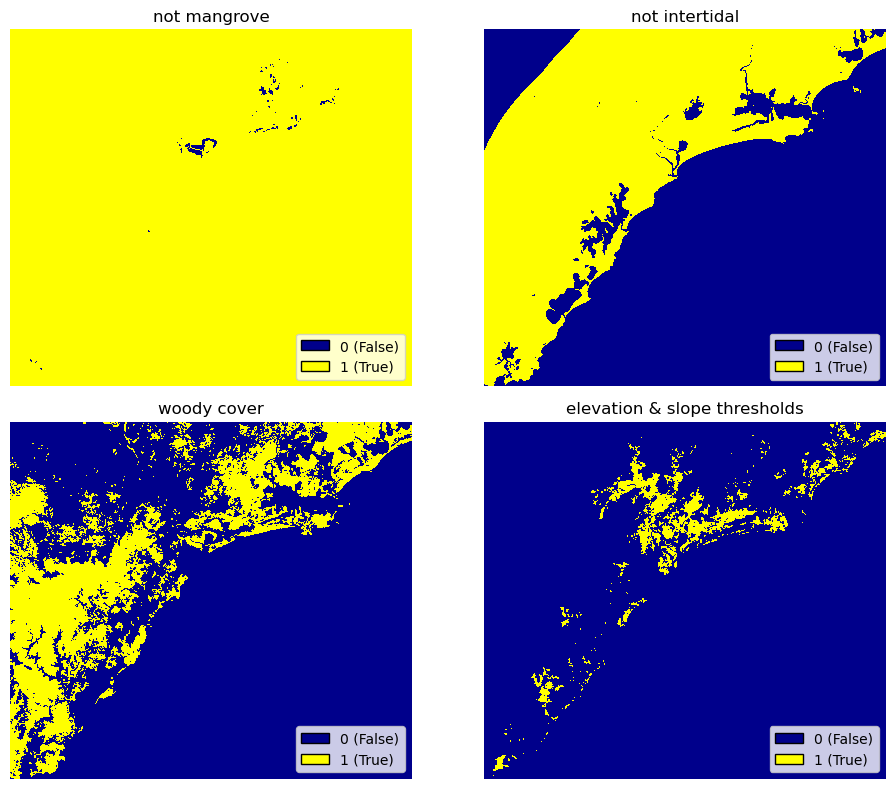

In [44]:
# Assuming you have four binary masks in a list with titles
binary_masks = [not_mangrove, not_intertidal, woody_cover, AHD_threshold_srtm,]

# Assuming you have a separate list of names for the subplots
subplot_names = ['not mangrove', 'not intertidal', 'woody cover', 'elevation & slope thresholds']

# Calculate the number of rows and columns for the subplot grid
num_rows = 2
num_cols = 2
num_subplots = num_rows * num_cols

# Create Figure and Axes objects for the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 8))

# Flatten the axs array to iterate through the subplots
axs = axs.flatten()

# Define the custom colormap for yellow and blue
cmap = plt.cm.colors.ListedColormap(['darkblue', 'yellow'])

# Iterate through your binary masks and plot them
for i in range(num_subplots):
    if i < len(binary_masks):
        binary_mask = binary_masks[i]
        ax = axs[i]
        
        # Use the custom colormap
        ax.imshow(binary_mask, cmap=cmap, vmin=0, vmax=1)
        
        if i < len(subplot_names):
            ax.set_title(subplot_names[i])  # Take title from the separate list
        ax.axis('off')

# Create artificial legends
legend_elements = [Patch(facecolor='darkblue', edgecolor='black', label='0 (False)'),
                   Patch(facecolor='yellow', edgecolor='black', label='1 (True)')]

# Add the legend to each subplot
for ax in axs:
    ax.legend(handles=legend_elements, loc='lower right')

# Adjust layout, save the figure and display the subplots
plt.tight_layout()
plt.savefig('binary_maps.png', dpi=300, format='png', bbox_inches='tight', transparent=True, facecolor='white')
plt.show()  # Diese Zeile hinzufügen, um die Abbildung anzuzeigen

Creation of a new binary map called "STF", based on certain conditions applied to four existing binary maps

(not_mangrove, AHD_threshold_srtm, not_intertidal, woody_cover)

In [25]:
### Combine masks

### AHD_threshold
#STF = xr.where((AHD_threshold_srtm == False), 0, 1).astype('int8')

### AHD_threshold + Not_mangrove
#STF = xr.where((AHD_threshold_srtm == False) + (not_mangrove == False), 0, 1).astype('int8')

### AHD_threshold + Not_mangrove + not_intertidal
#STF = xr.where((AHD_threshold_srtm == False) + (not_mangrove == False) + (not_intertidal == False), 0, 1).astype('int8')

### AHD_threshold + Not_mangrove + woody_cover
#STF = xr.where((not_mangrove == False) + (AHD_threshold_srtm == False) + (woody_cover == False), 0, 1).astype('int8')

### AHD_threshold + not_intertidal + woody_cover
#STF = xr.where((AHD_threshold_srtm == False) + (not_intertidal == False) + (woody_cover == False), 0, 1).astype('int8')

### Not_mangrove + AHD_threshold + not_intertidal + woody_vegetation_mask
STF = xr.where((not_mangrove == False) + (AHD_threshold_srtm == False) + (not_intertidal == False) + (woody_cover == False), 0, 1).astype('int8')

Visualization of the supratidal forest mask

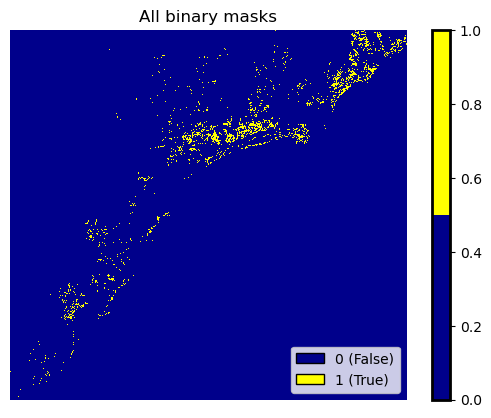

In [51]:
# Create the plot
STF.plot(cmap=cmap)

# Set the title
plt.title("All binary masks")

# Remove y and x-axis ticks and labels
plt.xticks([]), plt.yticks([])
plt.xlabel('')  # Remove x-axis label
plt.ylabel('')  # Remove y-axis label

# Hide the black frame around the plot
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Create artificial legends
legend_elements = [Patch(facecolor='darkblue', edgecolor='black', label='0 (False)'),
                   Patch(facecolor='yellow', edgecolor='black', label='1 (True)')]

plt.legend(handles=legend_elements, loc='lower right')

# Display the plot and save the figure
plt.savefig('STF_map.png', dpi=300, format='png', bbox_inches='tight', transparent=True, facecolor='white')
plt.show()

Output to GeoTIFF

In [27]:
# Set all pixels with a value of 0 to NaN
STF_black = STF.where(STF == 1, other=np.nan)

# Specify the output path for the GeoTIFF file
output_path = 'STF_Newcastle.tif'

# Save the modified DataArray as a GeoTIFF file
#STF_black.rio.to_raster(output_path)